# TOX24 Challenge

https://ochem.eu/static/challenge.do

### Goal 
Tox24 Challenge is designed to assess the progress in computational methods for predicting in vitro activity of compounds. The development of these methods has steadily gained momentum.

### Data
The chemicals and compounds being tested for activity against Transthyretin (TTR) within the “Toxicology in the 21st Century” (Tox21) initiative by the EPA will be used as the training and test sets for the Tox24 challenge. The initial dataset has been split into a training set (1012 compounds), a leaderboard set (200 compounds) and a blind set (300 compounds).

In [49]:
#import
import numpy as np
import pandas as pd
from rdkit import Chem
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, DataStructs
from sklearn.manifold import TSNE
from rdkit.Chem import Descriptors, rdMolDescriptors

In [91]:
datafile = pd.read_csv("QSPR-model/tox24_challenge_train.csv")

#### EDA

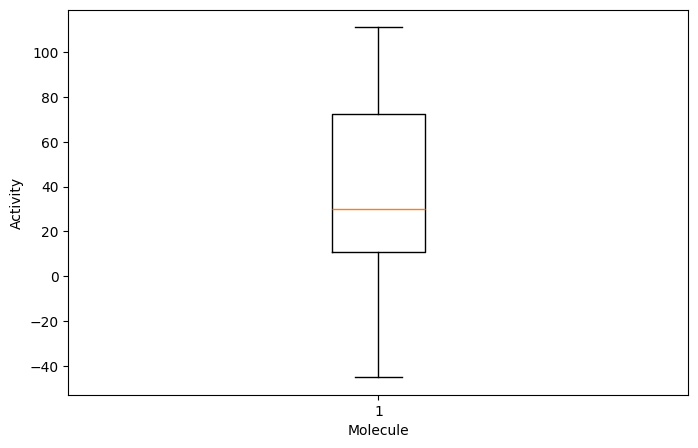

In [4]:
plt.figure(figsize=(8, 5))
plt.boxplot(datafile["activity"])
plt.xlabel("Molecule")
plt.ylabel("Activity")
plt.show()

In [92]:
#Number of atoms
def get_num_nodes(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumAtoms() if mol else 0

In [93]:
smiles_list = datafile["SMILES"].to_list()
activity_values = datafile["activity"].to_list()

In [94]:
datafile["atoms"] = [get_num_nodes(s) for s in smiles_list]

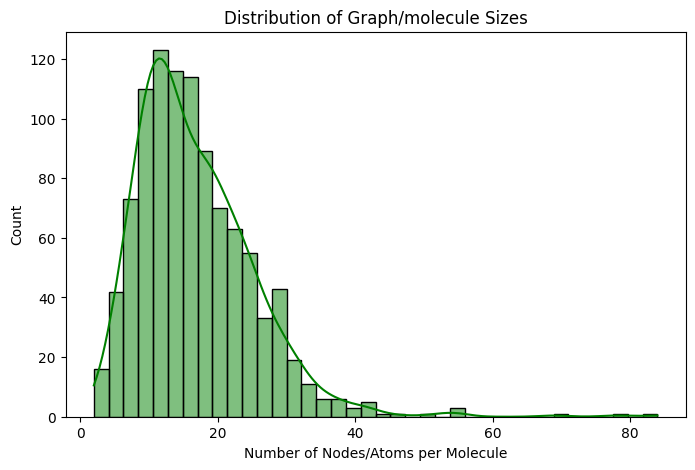

In [95]:
plt.figure(figsize=(8, 5))
sns.histplot(datafile["atoms"],  kde=True, color='g')
plt.xlabel("Number of Nodes/Atoms per Molecule")
plt.ylabel("Count")
plt.title("Distribution of Graph/molecule Sizes")
plt.show()

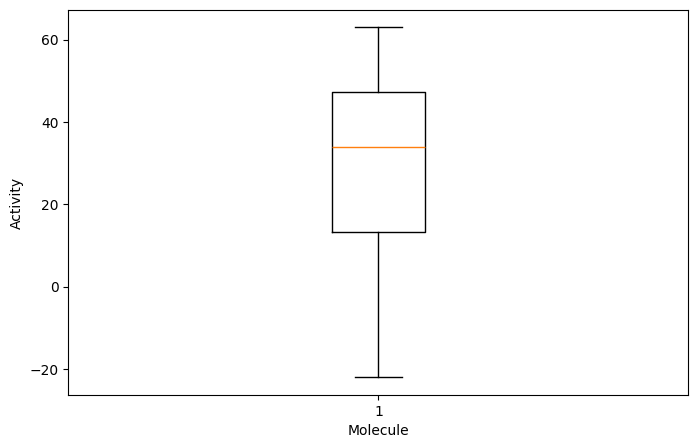

In [14]:
#outliers(based on size) above activity of 50
plt.figure(figsize=(8, 5))
plt.boxplot(datafile[datafile["atoms"]>50].activity)
plt.xlabel("Molecule")
plt.ylabel("Activity")
plt.show()

The molecules that can be outliers based on the size doesn't have abnormal activity (i.e., are not outliers w.r.t activity).  
Hence at this time its safe to assume that they wont create problem for the model, since they might share some pattern with others.

In [210]:
#datafile = datafile[datafile["atoms"]<=40]

In [15]:
size = datafile["atoms"].to_list()

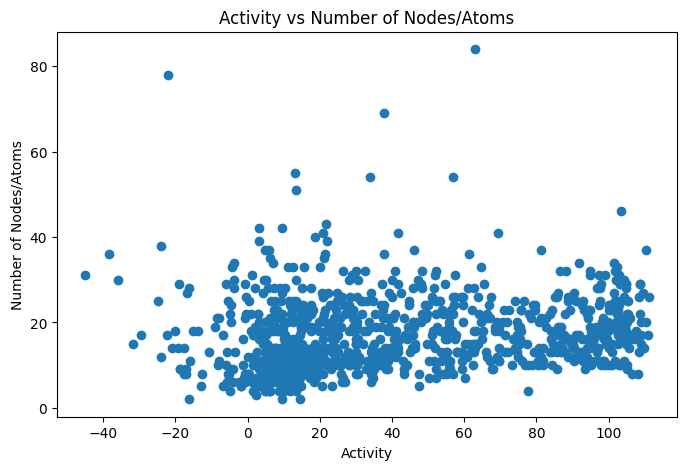

In [16]:
plt.figure(figsize=(8, 5))
plt.scatter(datafile.activity,datafile.atoms)
plt.xlabel("Activity")
plt.ylabel("Number of Nodes/Atoms")
plt.title("Activity vs Number of Nodes/Atoms")
plt.show()

As evident from above, size and activity doesn't correlate 

#### Chemical space

In [38]:
#Generating Morgan Fingerprint
def smiles_to_fingerprint(smiles, radius=3, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [39]:
fingerprints = np.array([smiles_to_fingerprint(s) for s in smiles_list if smiles_to_fingerprint(s) is not None])

[22:55:06] DEPRECATION WARNING: please use MorganGenerator
[22:55:06] DEPRECATION WARNING: please use MorganGenerator
[22:55:06] DEPRECATION WARNING: please use MorganGenerator
[22:55:06] DEPRECATION WARNING: please use MorganGenerator
[22:55:06] DEPRECATION WARNING: please use MorganGenerator
[22:55:06] DEPRECATION WARNING: please use MorganGenerator
[22:55:06] DEPRECATION WARNING: please use MorganGenerator
[22:55:06] DEPRECATION WARNING: please use MorganGenerator
[22:55:06] DEPRECATION WARNING: please use MorganGenerator
[22:55:06] DEPRECATION WARNING: please use MorganGenerator
[22:55:06] DEPRECATION WARNING: please use MorganGenerator
[22:55:06] DEPRECATION WARNING: please use MorganGenerator
[22:55:06] DEPRECATION WARNING: please use MorganGenerator
[22:55:06] DEPRECATION WARNING: please use MorganGenerator
[22:55:06] DEPRECATION WARNING: please use MorganGenerator
[22:55:06] DEPRECATION WARNING: please use MorganGenerator
[22:55:06] DEPRECATION WARNING: please use MorganGenerat

In [40]:
#tSNE

In [45]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50) #https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html
embedding = tsne.fit_transform(fingerprints)

In [46]:
df = pd.DataFrame(embedding, columns=["X", "Y"])
df["Activity"] = activity_values[:len(df)]
df["size"] = size[:len(df)]

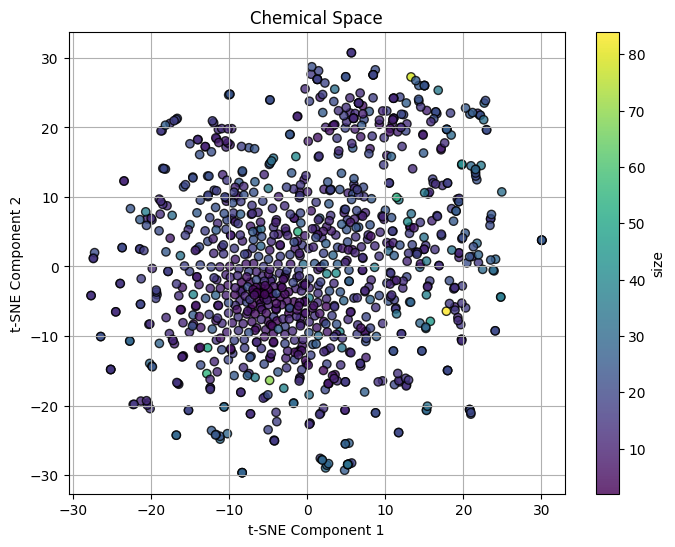

In [47]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df["X"], df["Y"], c=df["size"], cmap="viridis", edgecolors='k', alpha=0.8)
plt.colorbar(scatter, label="size")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Chemical Space")
plt.grid(True)
plt.show()

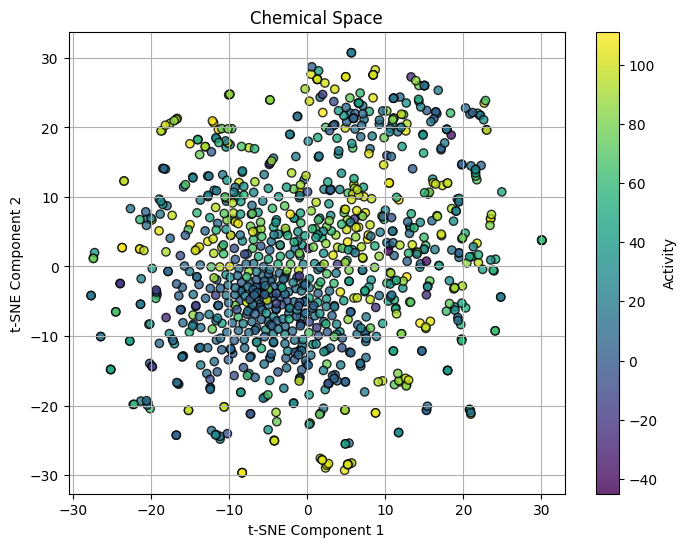

In [48]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df["X"], df["Y"], c=df["Activity"], cmap="viridis", edgecolors='k', alpha=0.8)
plt.colorbar(scatter, label="Activity")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Chemical Space")
plt.grid(True)
plt.show()

In [133]:
#adding more properties

In [134]:
def feature(smiles):
    mol = Chem.MolFromSmiles(smiles)
    logp = Descriptors.MolLogP(mol)  
    tpsa = Descriptors.TPSA(mol)
    hbd = Descriptors.NumHDonors(mol)  #Hydrogen Bond Donors
    hba = Descriptors.NumHAcceptors(mol)  #Hydrogen Bond Acceptors
    rotatable_bonds = Descriptors.NumRotatableBonds(mol) 
    f_sp3 = rdMolDescriptors.CalcFractionCSP3(mol)  #Fraction sp3 Carbon
    num_rings = rdMolDescriptors.CalcNumRings(mol) 
    aromatic_rings = rdMolDescriptors.CalcNumAromaticRings(mol)
    formal_charge = Chem.GetFormalCharge(mol)
    return [smiles,logp,tpsa,hbd,hba,rotatable_bonds,f_sp3,num_rings,aromatic_rings,formal_charge]

In [135]:
list_dict=[]
for i in datafile["SMILES"]:
    list_dict.append(feature(i))

In [136]:
prop = pd.DataFrame(list_dict)

In [137]:
prop.columns = ["SMILES","logp","tpsa","hbd","hba","rotatable_bonds","f_sp3","num_rings","aromatic_rings","formal_charge"]

In [138]:
data_prop = datafile.merge(prop,on="SMILES").drop_duplicates()

In [139]:
#are the properties correlated with activity!

In [121]:
data_prop.corr()["activity"]

C:\Users\shasa\AppData\Local\Temp\ipykernel_26508\2089577405.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_prop.corr()["activity"]


activity           1.000000
atoms              0.188243
logp               0.194060
tpsa               0.083635
hbd                0.028859
hba                0.079283
rotatable_bonds    0.027226
f_sp3             -0.322358
num_rings          0.137047
aromatic_rings     0.338899
formal_charge     -0.029662
Name: activity, dtype: float64

Fraction sp3 Carbon and number of aromatic rings shows kind off ok correlation

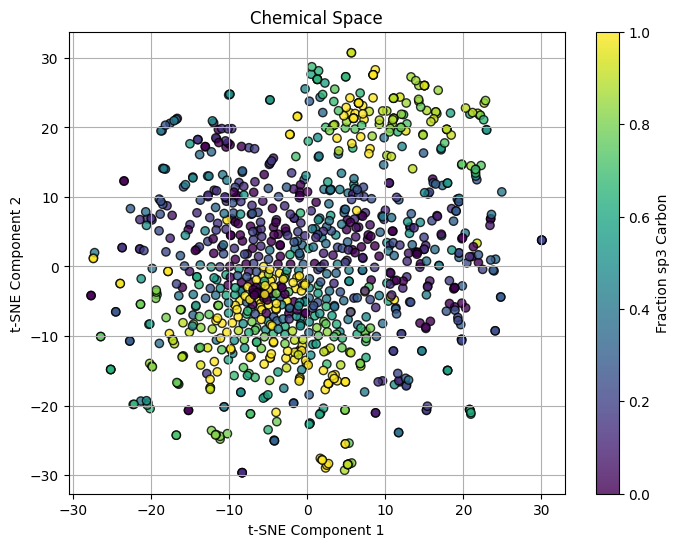

In [125]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df["X"], df["Y"], c=data_prop["f_sp3"], cmap="viridis", edgecolors='k', alpha=0.8)
plt.colorbar(scatter, label="Fraction sp3 Carbon")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Chemical Space")
plt.grid(True)
plt.show()

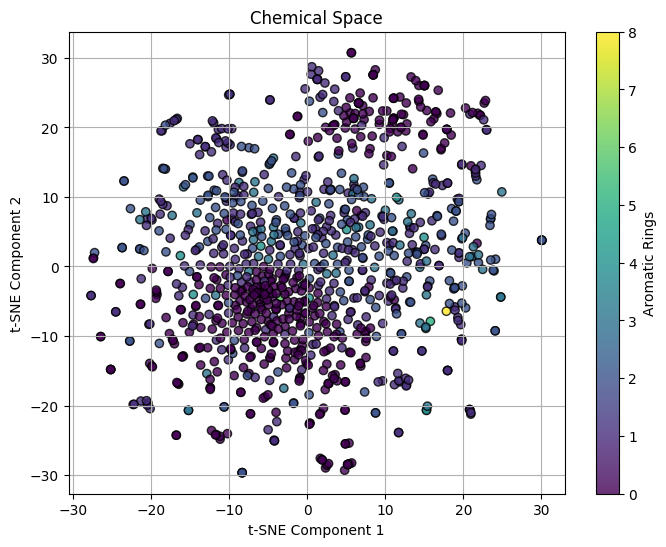

In [126]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df["X"], df["Y"], c=data_prop["aromatic_rings"], cmap="viridis", edgecolors='k', alpha=0.8)
plt.colorbar(scatter, label="Aromatic Rings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Chemical Space")
plt.grid(True)
plt.show()

#### Conclusion

The chemical space plots pushes the idea of QSPR i.e., the structural properties like numner of atoms, logp, fraction of sp3 carbor, number of rings and number of aromatic rings shows good correlation with activity.  
Hence with more structural properties along with fingerprints we might build a model to accuratly predict activity

#### Approaches:  
1. QSPR Models [`Descriptors` model, `Fingerprint` model, (`Descriptors + Fingerprint`) model]
2. Graph based model (Graph attention network)